## Methods primer

Trying out some of the methods used in the paper: 
* Jae-Joong Lee, Hong Ji Kim, Marta Ceko, Bo-yong Park, Soo Ahn Lee, Hyunjin Park, Mathieu Roy, Seong-Gi Kim, Tor D. Wager*, Choong-Wan Woo*, A neuroimaging biomarker for sustained experimental and clinical pain, 2020, Nature Medicine (*co-corresponding authors)

### Setup

In [1]:
import numpy as np
import pandas as pd
import scipy.io
from scipy.linalg import eigh
import statsmodels.api as sm
import matplotlib.pyplot as plt
from nilearn import plotting

### Example data

Authors provided example data, available for download on [figshare](https://figshare.com/articles/dataset/data_zip/13082519). They also provided MATLAB tutorials on how to use their model on [Github](https://github.com/cocoanlab/tops). 

In [2]:
# data including atlas, imaging data of example participant, and all trained participants functional connectivity
! tree ./data

./data
├── atlas
│   ├── Fan_et_al_atlas_r279_MNI_2mm.nii
│   ├── Fan_et_al_atlas_r279_MNI_3mm.nii
│   └── cluster_Fan_Net_r279.mat
├── example_participant
│   ├── FC
│   │   ├── example_dFC_binned_task-CAPS.mat
│   │   └── example_dFC_binned_task-REST.mat
│   ├── ROI
│   │   ├── example_ROI_mean_timeseries_task-CAPS.mat
│   │   └── example_ROI_mean_timeseries_task-REST.mat
│   ├── fMRI
│   │   ├── example_preprocessed_fMRI_task-CAPS.nii.gz
│   │   └── example_preprocessed_fMRI_task-REST.nii.gz
│   └── pain_rating
│       ├── example_pain_rating_task-CAPS.mat
│       └── example_pain_rating_task-REST.mat
└── whole_participants
    └── FC_and_pain
        └── merged_FC_and_pain_rating.mat

8 directories, 12 files


### Step 1. Brain parcellation

4 different brain atlases were used to extract ROI time series. The winning model used the 279-region Brainnetome parcellation (plotted below).

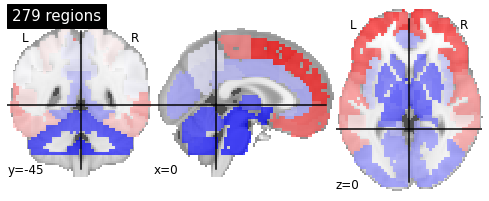

In [24]:
atlas_img = './data/atlas/Fan_et_al_atlas_r279_MNI_3mm.nii'
plotting.plot_roi(atlas_img, cmap=plotting.cm.bwr_r, title='279 regions')

In [25]:
mat = scipy.io.loadmat('./data/atlas/cluster_Fan_Net_r279.mat')# load mat-file
labels = np.squeeze(mat['cluster_Fan_Net']['names'][0,0])
labels = [l[0] for l in labels]
df_labels = pd.Series(labels,dtype=str)

In [26]:
df_labels[:5].values

array(['SFG_L_7_1 (8m)', 'SFG_R_7_1 (8m)', 'SFG_L_7_2 (8dl)',
       'SFG_R_7_2 (8dl)', 'SFG_L_7_3 (9l)'], dtype=object)

Then the ROI-mean time series were extracted (using nilearn instead of FSL meants here).

In [27]:
# capsaicin session
# caps_img = './data/example_participant/fMRI/example_preprocessed_fMRI_task-CAPS.nii.gz'
caps_img = './data/example_participant/fMRI/example_preprocessed_fMRI_task-REST.nii.gz'

from nilearn.input_data import NiftiLabelsMasker
masker = NiftiLabelsMasker(labels_img=atlas_img, standardize=True,
                           memory='nilearn_cache', verbose=5)
time_series = masker.fit_transform(caps_img)

[NiftiLabelsMasker.fit_transform] loading data from ./data/atlas/Fan_et_al_atlas_r279_MNI_3mm.nii
________________________________________________________________________________
[Memory] Calling nilearn.input_data.base_masker.filter_and_extract...
filter_and_extract('./data/example_participant/fMRI/example_preprocessed_fMRI_task-REST.nii.gz', <nilearn.input_data.nifti_labels_masker._ExtractionFunctor object at 0x7fbc9096cbb0>, 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'labels_img': './data/atlas/Fan_et_al_atlas_r279_MNI_3mm.nii',
  'low_pass': None,
  'mask_img': None,
  'smoothing_fwhm': None,
  'standardize': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, dtype=None, memory=Memory(location=nilearn_cache/joblib), memory_level=1, verbose=5)
[NiftiLabelsMasker.transform_single_imgs] Loading data from ./data/example_participant/fMRI/example_preprocessed_fMRI_task-REST.nii.gz
[NiftiL

In [28]:
print(time_series.shape)

(2586, 279)


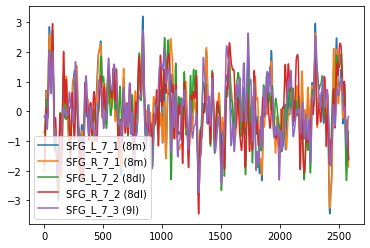

In [29]:
# plotting random
plt.plot(time_series[:,:5])
plt.legend(labels[:5])

### Step 2. Correlation

Then they used 2 different correlaiton methods:
* Static correlation (Pearson's correlation)
* Dynamic correlation (dynamic conditional correlation, DCC) (Lindquist, M. A., Xu, Y., Nebel, M. B. & Caffo, B. S. Evaluating dynamic bivariate correlations in resting-state fMRI: a comparison study and a new approach. Neuroimage 101, 531–546 (2014).)

#### Static correlation (each time series produces 1 corrcoef)

In [30]:
# Pearson correlation 
corr_matrix = np.corrcoef(time_series.T)

In [31]:
corr_matrix.shape

(279, 279)

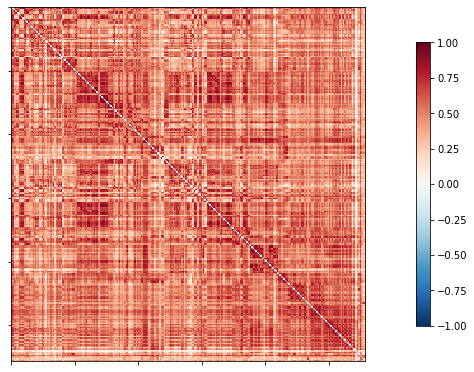

In [32]:
# Display the correlation matrix
# Mask out the major diagonal
np.fill_diagonal(corr_matrix, 0)
# plotting.plot_matrix(corr_matrix[:30,:30], labels=labels[:30], 
#                      colorbar=True, vmax=1., vmin=-1.)
plotting.plot_matrix(corr_matrix, colorbar=True, vmax=1., vmin=-1.)

#### Dynamic correlation

DCC is based on generalised autoregressive conditional heteroscedastic (GARCH) and exponentially weighted moving average (EWMA) models. It has been shown to have better sensitivity and specificity in capturing dynamical changes in correlation compared to the conventional sliding window dynamic correlation method. 

* Autoregressive model (AR) 

Dependent variable is regressed against lagged values of itself. An AR(2) model has 2 lagged variables.

$$ x_t = \alpha_1 x_{t-1} + ... + \alpha_p x_{t-p} + \omega_t $$

In [33]:
# Simulate an AR(2) process with alpha = 0.6

np.random.seed(1)
n_samples = int(1000)
a1 = 0.6
a2 = 0.3
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a1*x[t-1] + a2*x[t-2] + w[t]

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 2)'>

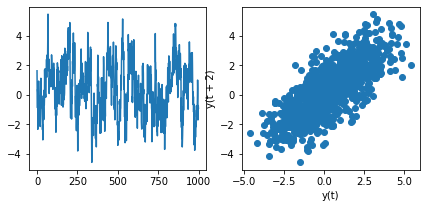

In [34]:
# AR(2) series has a linear lag plot
df_x = pd.Series(x)
fig, ax = plt.subplots(1,2, figsize=(7,3))
df_x.plot(ax=ax[0])
pd.plotting.lag_plot(df_x, lag=2, ax=ax[1])

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 2)'>

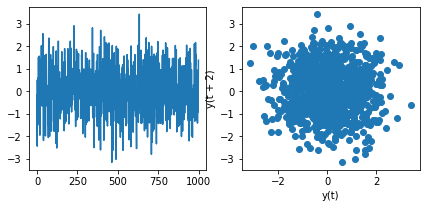

In [35]:
# random sequence doesn't
df_x = pd.Series(np.random.normal(size=n_samples))
fig, ax = plt.subplots(1,2, figsize=(7,3))
df_x.plot(ax=ax[0])
pd.plotting.lag_plot(df_x, lag=2, ax=ax[1])

* Moving average (MA) model

A linear combination of past white noise error terms as opposed to past observations in AR.

$$ x_t = \omega_t + \beta_t \omega_{t-1} + ... + \beta_p \omega_{t-p} $$

In [36]:
# Simulate an MA(2) process with alpha = 0.6

np.random.seed(1)
n_samples = int(1000)
a1 = 0.9
a2 = 0.5
w = np.random.normal(size=n_samples+2)

for t in range(n_samples):
    x[t] = w[t+2] + a1*w[t+1] + a2*w[t]

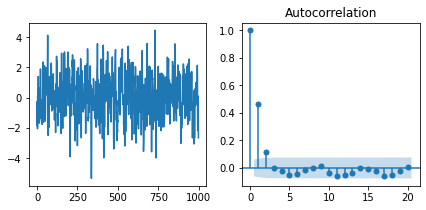

In [37]:
from statsmodels.graphics.tsaplots import plot_acf
df_x = pd.Series(x)
fig, ax = plt.subplots(1,2,figsize=(7,3))
df_x.plot(ax=ax[0])
_ = plot_acf(np.square(df_x), lags=20, ax=ax[1])

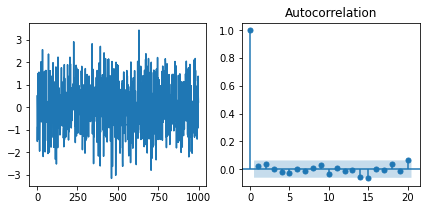

In [38]:
# compare to a random sequence
df_x = pd.Series(np.random.normal(size=n_samples))
fig, ax = plt.subplots(1,2,figsize=(7,3))
df_x.plot(ax=ax[0])
_ = plot_acf(np.square(df_x), lags=20, ax=ax[1])

DCC uses exponential weighted moving average (EWMA), which is similar moving average but include declining weights to past observations based on $\lambda$. 

$$ \Sigma_t = (1-\lambda) \omega_{t-1} + \lambda \Sigma_{t-1} $$

* Autoregressive moving average (ARMA) model

Merging between AR and MA models. AR captures momentum and mean reversion effects, MA captures shock effects in noise terms.

$$ x_t = a_1 x_{t-1} + a_2 x_{t-2} + ... + \omega_t + \beta_1 \omega_{t-1} + \beta_2 \omega_{t-2} + ...$$

ARMA can be used to transform signal covanriance matrix to ones with identity covaraince matrix (whitening).

In [39]:
# the paper used this step to the time series data
whitened_ts = np.empty_like(time_series)
for k in range(time_series.shape[1]):
    res = sm.tsa.arima.ARIMA(time_series[:,k], order=(1, 0, 1)).fit()
    whitened_ts[:,k] = res.resid

/Users/syzhang/opt/anaconda3/envs/img/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/syzhang/opt/anaconda3/envs/img/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/syzhang/opt/anaconda3/envs/img/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/syzhang/opt/anaconda3/envs/img/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

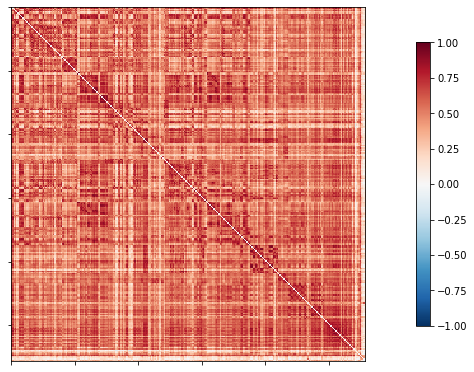

In [40]:
whitened_corr = np.corrcoef(whitened_ts.T)
np.fill_diagonal(whitened_corr, 0)
plotting.plot_matrix(whitened_corr, colorbar=True, vmax=1., vmin=-1.)

* Autoregressive conditionally heteroskedastic (ARCH) model

AR(p) model applied to the variance of a time series, i.e. variance at time t is conditional on past variance.

$$ Var(y_t|y_{t-1}) = \sigma_t^2 = \alpha_0 + \alpha_1 y^2_{t-1}$$

In [41]:
# Simulate ARCH(1) series
# Var(yt) = a_0 + a_1*y{t-1}**2
# if a_1 is between 0 and 1 then yt is white noise

np.random.seed(1)
a0 = 1
a1 = 10
y = w = np.random.normal(size=1000)
Y = np.empty_like(y)

for t in range(len(y)):
    Y[t] = w[t] * np.sqrt((a0 + a1*y[t-1]**2))

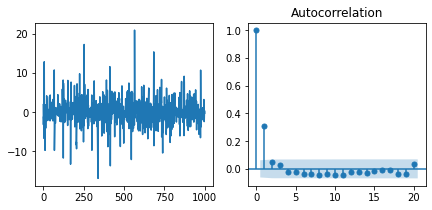

In [42]:
# ARCH(1) 
from statsmodels.graphics.tsaplots import plot_acf
df_x = pd.Series(Y)
fig, ax = plt.subplots(1,2,figsize=(7,3))
df_x.plot(ax=ax[0])
_ = plot_acf(np.square(df_x), lags=20, ax=ax[1])

* Generalised autoregressive conditional heteroskedastic (GARCH) model

An ARMA model applied to the variance of the time series with both autoregressive and moving average terms. $\alpha$ controls impact of past values of the time series on the variance, $\beta$ controls impact of past values of the conditional variance on its present value.

$$ \epsilon_t = \sigma_t \omega_t $$
$$ \sigma_t^2 = \alpha_0 + \alpha_1 \epsilon_{t-1}^2 + \beta_1 \sigma_{t-1}^2$$

If setting $\alpha_0=0$, $\alpha_1=1-\lambda$, $\beta_1=\lambda$, GARCH(1,1) above becomes:

$$ \sigma_t^2 = (1-\lambda)\eta_{t-1}^2 + \lambda \sigma_{t-1}^2 $$

equivalent to EWMA (GARCH(1,1) provides a generalisation of EWMA)

In [43]:
# Simulating a GARCH(1, 1) process

np.random.seed(2)

a0 = 0.2
a1 = 0.5
b1 = 0.3

n = 1000
w = np.random.normal(size=n)
eps = np.zeros_like(w)
sigsq = np.zeros_like(w)

for i in range(1, n):
    sigsq[i] = a0 + a1*(eps[i-1]**2) + b1*sigsq[i-1]
    eps[i] = w[i] * np.sqrt(sigsq[i])

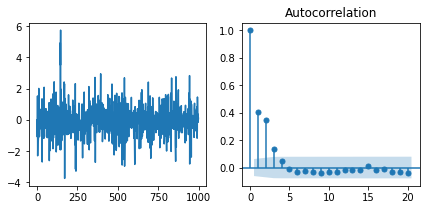

In [44]:
# GARCH(1) 
df_x = pd.Series(eps)
fig, ax = plt.subplots(1,2,figsize=(7,3))
df_x.plot(ax=ax[0])
_ = plot_acf(np.square(df_x), lags=20, ax=ax[1])

In [45]:
# GARCH model of simulated data
from arch import arch_model
am = arch_model(eps)
res = am.fit(update_freq=5)
print(res.params)

Iteration:      5,   Func. Count:     32,   Neg. LLF: 1235.5962182894755
Iteration:     10,   Func. Count:     60,   Neg. LLF: 1222.490441371813
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1222.4904385231052
            Iterations: 12
            Function evaluations: 69
            Gradient evaluations: 12
mu         -0.021532
omega       0.239894
alpha[1]    0.530438
beta[1]     0.228476
Name: params, dtype: float64


In DCC (Lindquist, M. A., Xu, Y., Nebel, M. B. & Caffo, B. S. Evaluating dynamic
bivariate correlations in resting-state fMRI: a comparison study and a new
approach. Neuroimage 101, 531–546 (2014).)

1. Each time series was modelled with a GARCH(1,1) model, returning a set of GARCH parameters ($\omega_i$, $\alpha_p$, $\beta_q$), and obtained standardised residuals (equations 19-21 below).
2. EWMA method was applied to the standardised residuals to compute a non-normalised version of the time-varying correlation matrix / dynamic conditional correlations $R_t$ (size p*(p-1)/2 x T)

![fishy](./dcc.png)

#### see 'dcc_garch' notebook for more information.

### Step 3: regression

The winning model was principal component regression (PCR) with 21 PCs for pain intensity and 26 PCs for pain unpleasantness model. PCA is a dimensionality reduction technique. A good tutorial can be found on Neuromatch academy [course page (W1D5)](http://www.neuromatchacademy.org/syllabus).

In [59]:
# reducing DCC_out to 21PC
def get_sample_cov_matrix(X):
    """
    Returns the sample covariance matrix of data X
    Args:
    X (numpy array of floats) : Data matrix each column corresponds to a
                                different random variable
    Returns:
    (numpy array of floats)   : Covariance matrix
    """

    # Subtract the mean of X
    X = X - np.mean(X, 0)
    # Calculate the covariance matrix (hint: use np.matmul)
    cov_matrix =  1 / X.shape[0] * np.matmul(X.T, X)

    return cov_matrix

def sort_evals_descending(evals, evectors, n_components=None):
    """
    Sorts eigenvalues and eigenvectors in decreasing order. Also aligns first two
    eigenvectors to be in first two quadrants (if 2D).

    Args:
    evals (numpy array of floats)    : Vector of eigenvalues
    evectors (numpy array of floats) : Corresponding matrix of eigenvectors
                                        each column corresponds to a different
                                        eigenvalue

    Returns:
    (numpy array of floats)          : Vector of eigenvalues after sorting
    (numpy array of floats)          : Matrix of eigenvectors after sorting
    """

    index = np.flip(np.argsort(evals))
    if n_components is not None:
        index = index[:n_components]
    evals = evals[index]
    evectors = evectors[:, index]
#     if evals.shape[0] == 2:
#         if np.arccos(np.matmul(evectors[:, 0],
#                            1 / np.sqrt(2) * np.array([1, 1]))) > np.pi / 2: evectors[:, 0] = -evectors[:, 0]
#         if np.arccos(np.matmul(evectors[:, 1],
#                            1 / np.sqrt(2) * np.array([-1, 1]))) > np.pi / 2:evectors[:, 1] = -evectors[:, 1]
    return evals, evectors

def change_of_basis(X, W):
    """
    Projects data onto a new basis.

    Args:
    X (numpy array of floats) : Data matrix each column corresponding to a
                                different random variable
    W (numpy array of floats) : new orthonormal basis columns correspond to
                                basis vectors

    Returns:
    (numpy array of floats)   : Data matrix expressed in new basis
    """

    Y = np.matmul(X, W)
    return Y


def pca(X, n_components):
    """
    Performs PCA on multivariate data.
    Args:
    X (numpy array of floats) : Data matrix each column corresponds to a
                                different random variable
    Returns:
    (numpy array of floats)   : Data projected onto the new basis
    (numpy array of floats)   : Vector of eigenvalues
    (numpy array of floats)   : Corresponding matrix of eigenvectors
    """

    # Subtract the mean of X
    X = X - np.mean(X, axis=0)
    # Calculate the sample covariance matrix
    cov_matrix = get_sample_cov_matrix(X)
    # Calculate the eigenvalues and eigenvectors
    evals, evectors = np.linalg.eigh(cov_matrix)
    # Sort the eigenvalues in descending order
    evals, evectors = sort_evals_descending(evals, evectors, n_components)
    # Project the data onto the new eigenvector basis
    score = change_of_basis(X, evectors)

    return score, evectors, evals

In [61]:
# paper concatenated capsaicin and control sessions
DCC_caps = np.load('./DCC_caps.npy')
DCC_rest = np.load('./DCC_rest.npy')
DCC_out = np.concatenate((DCC_caps, DCC_rest), axis=1)
print(DCC_out.shape)

(38781, 10)


In [62]:
# takes a very long time on original matrix, reducing size for demo purposes
DCC_reduced = DCC_out[:-1:10,:]
DCC_pca, evectors, evals = pca(DCC_reduced.T, n_components=21)
print(DCC_pca.shape)

(10, 21)


In [63]:
def get_variance_explained(evals):
    """
    Plots eigenvalues.
    Args:
    (numpy array of floats) : Vector of eigenvalues
    Returns:
    Nothing.
    """

    # cumulatively sum the eigenvalues
    csum = np.cumsum(evals)
    # normalize by the sum of eigenvalues
    variance_explained = csum / np.sum(evals)

    return variance_explained

In [64]:
var_explained = get_variance_explained(evals)

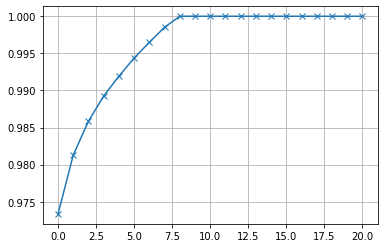

In [65]:
plt.plot(var_explained, 'x-')
plt.grid(True)

### Step 4: training and cross validation

After obtaining the reduced PCs (DCC_pca), simple linear regressions were fitted to pain intensity. Leave one out cross validation was used both within and across subjects (with Pearson correlation between predicted and actual pain intensity). They derived 7 criteria from 2 data sets (Study 1 and 2), producing 7 0-100 scores. Finally, they picked the method with highest score as best model.

In [75]:
mat = scipy.io.loadmat('./data/example_participant/pain_rating/example_pain_rating_task-CAPS.mat')# load mat-file
caps_rating = np.squeeze(mat['pain_rating_dat'])
mat = scipy.io.loadmat('./data/example_participant/pain_rating/example_pain_rating_task-REST.mat')# load mat-file
rest_rating = np.squeeze(mat['pain_rating_dat'])

In [77]:
ratings = np.concatenate([caps_rating, rest_rating])

In [80]:
ratings

array([0.51434056, 0.46159454, 0.41647264, 0.37879592, 0.38475508,
       0.08723456, 0.02462516, 0.01468772, 0.03134323, 0.01333911])

In [102]:
# within subject prediction
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
X = DCC_pca
y = ratings
kf = KFold(n_splits=len(y))
mse = 0.
for train, test in kf.split(X):
    X_train = X[train, :]
    y_train = y[train]
    X_test = X[test, :]
    y_test = y[test]
    # model
    regr = linear_model.LinearRegression()
    # Train the model using the training sets
    regr.fit(X_train, y_train)
    # Make predictions using the testing set
    y_pred = regr.predict(X_test)
    # The mean squared error
    mse += (y_test-y_pred)**2.
print('Mean squared error: %.3f' % (mse/len(y)))

Mean squared error: 0.002


In [104]:
# reconstruction of weights
coef = regr.coef_
print(coef.shape)

(21,)


In [105]:
def reconstruct_data(score, evectors, X_mean):
    """
    Reconstruct the data based on the components.
    Args:
    score (numpy array of floats)    : Score matrix
    evectors (numpy array of floats) : Matrix of eigenvectors
    X_mean (numpy array of floats)   : Vector corresponding to data mean
    Returns:
    (numpy array of floats)          : Matrix of reconstructed data
    """

    # Reconstruct the data from the score and eigenvectors
    # Don't forget to add the mean!!
    X_reconstructed =  np.matmul(score, evectors.T) + X_mean

    return X_reconstructed

In [106]:
# reconstructing using eigen vectors from earlier
DCC_weights = reconstruct_data(coef, evectors, 0)

In [107]:
# reduced size
DCC_weights.shape

(3878,)

#### see 'cross_validation' notebook for more information on model selection.